In [22]:
"""
This file is implementing the vanilla LSTM.
The test set used are the 31 days of December of a single time-serie of the 261 time-series with measurements of the full year 2017.
Missing days are estimated.
Naive basemodels that are used are the mean forecast and the MAPE-minimization.
Evaluation metrics used: MSE, RMSE, NRMSE, MAE
####################################################

calculate the MSE on the total test set and for each day of the week.
Should normalize history and temperature with min max
Rest: weekday, time, holiday use one hot encoder
Stack different LSTM blocks --> hidden nodes serve as inputs for next LSTM's
Use finally a fully connected layer to generate an output
Use different learning rules: adam!!, stochastic gradient descent, Adagrad, Adadelta and RMSProp
Adam has parameters: learning rate, momentum and decay
play with mini batches

Inputs:
1. history ok
2. temp ok
3. day week ok
4. time ok
5. holiday
6. (previous week future lag)
7. previous week error history lag --> how good are you following previous week
just the difference between the values
8. previous weeks load at the same moment in time and the temperatures of these days
"""


"\nThis file is implementing the vanilla LSTM.\nThe test set used are the 31 days of December of a single time-serie of the 261 time-series with measurements of the full year 2017.\nMissing days are estimated.\nNaive basemodels that are used are the mean forecast and the MAPE-minimization.\nEvaluation metrics used: MSE, RMSE, NRMSE, MAE\n####################################################\n\ncalculate the MSE on the total test set and for each day of the week.\nShould normalize history and temperature with min max\nRest: weekday, time, holiday use one hot encoder\nStack different LSTM blocks --> hidden nodes serve as inputs for next LSTM's\nUse finally a fully connected layer to generate an output\nUse different learning rules: adam!!, stochastic gradient descent, Adagrad, Adadelta and RMSProp\nAdam has parameters: learning rate, momentum and decay\nplay with mini batches\n\nInputs:\n1. history\n2. temp\n3. day week\n4. time\n5. temperature\n6. (previous week future lag)\n7. previous 

In [23]:
import datetime as dt
import pandas as pd # pandas
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import casadi as ca
from Test_basemodel_functions import *

plt.rc('axes', linewidth=2)
plt.rc('axes', labelsize= 16)
plt.rc('axes',titlesize = 18)
plt.rc('legend',fontsize=14)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('figure',figsize=(10,8))


In [24]:
# importing the data
fullYeardata = pd.read_csv("D:\Onedrive\Leuven\Final project\data\Forecasting_writtendata\FullYear.csv",index_col= "date",parse_dates= True)
av_temperature = pd.read_csv("D:\Onedrive\Leuven\Final project\data\weather-avg.csv",index_col='meter_id')
av_temperature = av_temperature.transpose()
av_temperature.index = pd.to_datetime(av_temperature.index)

In [25]:
name = fullYeardata.columns[0]
TS = fullYeardata[name]
temperature = av_temperature[name]

In [26]:
# subsitute the missing values by prev week < prev day < mean of all the values at that time of the day (rarely used)
def substitute_missing_values(TS: pd.Series):
    for date in TS.index:
        if np.isnan(TS[date]):
            prev_week =  date + dt.timedelta(days=-7)
            prev_day = date + dt.timedelta(days=-1)
            if not np.isnan(TS[prev_week]):
                TS[date] = TS[prev_week]

            elif not np.isnan(TS[prev_day]):
                TS[date] = TS[prev_day]

            else:
                temp = TS[TS.index.hour == date.hour]
                data = temp[temp.index.minute == date.minute]
                TS[date] = data.mean()
    print("amount of missing values: %s. \n"%TS.isnull().sum())
    return TS

In [27]:
# normalize the data --> min/max method (when using a single time serie)
temperature_norm = norm(temperature)
TS_norm = norm(TS)
temp = TS_norm[TS_norm.index.month != 12]
training = temp[temp != 11]
validation = TS_norm[TS_norm.index.month == 11]
test = TS_norm[TS_norm.index.month == 12]
# remove from the test set all the days that contain nan values -> only estimate real days
test.dropna(inplace=True)
# substitute the missing values
training = substitute_missing_values(training)

amount of missing values: 0. 



<AxesSubplot:xlabel='date'>

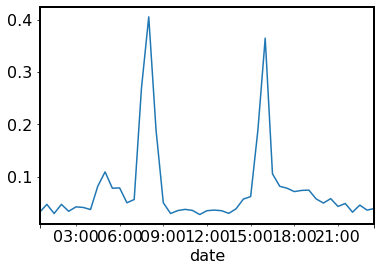

In [11]:
def get_av_temp(time_stamp: pd.Timestamp,temperature: pd.Series)-> float:
    return temperature[temperature.index.dayofyear == time_stamp.dayofyear]

def get_weekday(time_stamp: pd.Timestamp)-> int:
    return 

# forecast one time stamp at the time --> for loop to forecast the 48 time stamps
def input_output_LSTM(training, temperature_norm, lag_value: int):
    amount_forecasts = len(training) - lag_value

    history = np.zeros((amount_forecasts,lag_value))
    temperature_feed = np.zeros((amount_forecasts,1))
    weekday = np.zeros((amount_forecasts,7))
    time = np.zeros((amount_forecasts,48))
    holiday = np.zeros((amount_forecasts,2))

    y_des = training[lag_value:].values.squeeze()

    for sample_id in np.arange(0,amount_forecasts):
        time_stamp = training.index[lag_value + sample_id]
        history[sample_id,:] = training.values[sample_id:lag_value + sample_id]
        temperature_feed[sample_id,:] = get_av_temp(time_stamp,temperature_norm)
        day = get_weekday(time_stamp) # 0 - 6
        weekday[sample_id,day] = 1
        time_of_day = get_daytime(time_stamp) # 0 - 47
        time[sample_id,time_of_day] = 1
        hol = is_holiday(time_stamp) # boolean
        if hol:
            holiday[sample_id,1] = 1
        else:
            holiday[sample_id,0] = 0

